# Transfer Learning
> Basics on transfer learning

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: 


##Introduction
[Transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) allows us to use trained layers from other models and apply them to our models. We can save time and resources by not having to train large networks.

##Objective
We want to classify the images in the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. It contains 60,000 images in 10 classes.

##Approach
Here we use a well known pre-trained model (ResNet50) for image classification. On top of it, we add some fully connected layers to classify the learned features into ten categories.

###1.Import Libraries

In [1]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

###2. Load the dataset
CIFAR10 dataset is readily accessible through keras.

In [2]:
(train_img, train_lbl), (test_img, test_lbl) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 12s 0us/step


###3. Preprocess images
[Pre-processing](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) converts RGB to BGR, zero-centers each color channel with respect to the ImageNet dataset.

In [3]:
train_img = (train_img).astype('float32')
test_img = (test_img).astype('float32')
train_img = tf.keras.applications.resnet50.preprocess_input(train_img)
test_img = tf.keras.applications.resnet50.preprocess_input(test_img)

NUM_EPOCHS = 20
print('Test images: ', test_img.shape)
print('Train images: ', train_img.shape)

Test images:  (10000, 32, 32, 3)
Train images:  (50000, 32, 32, 3)


###4. Load ResNet50 model
Use weights from imagenet, do not include the top layers, and freeze each layer to not-trainable. We want to use the trained model as is with some modifications.

In [4]:
# get pre trained model
pre_trained_model = ResNet50(input_shape = (224, 224, 3), weights='imagenet', classes = 10, include_top = False)
for layer in pre_trained_model.layers:
  layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


###5. Create model

- Specify shape of images for input.
- Upsample image size by 7x to match ResNet50 architecture.
- Add the pre-trained model.
- Flatten the output of the model.
- Add a few dense layers to adapt the model to your dataset. Use the relu activation function.
- Specify the output with 10 output categories and a softmax activation.

In [5]:
inputs = tf.keras.layers.Input(shape=(32,32,3))
x = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
x = (pre_trained_model)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(10, activation='softmax')(x)
tx_model = tf.keras.Model(inputs = inputs, outputs = x)

###6. Compile model

Use Stochastic Gradient Descent for optimization, sparse categorical crossentropy as the loss parameter, and accuracy as the metric. Then fit the model using the training images and labels.

In [6]:
tx_model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
tx_model.summary()
history = tx_model.fit(train_img, train_lbl, batch_size=256, epochs = NUM_EPOCHS, validation_data = (test_img, test_lbl), verbose = 1) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

###7. Plot results
Plot the response (accuracy and loss) by epochs for the training and validation sets.

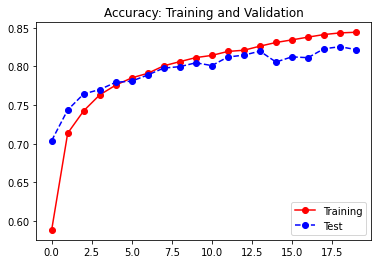

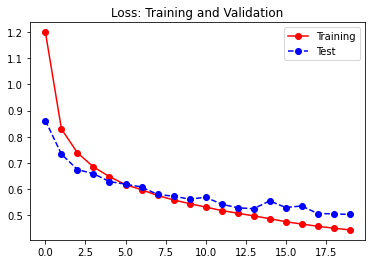

In [7]:
# plot accuracy and loss
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'o-r', label='Training')
plt.plot(epochs, val_acc, 'o--b', label='Test')
plt.title('Accuracy: Training and Validation')
plt.legend(loc="lower right")
plt.figure()

plt.plot(epochs, loss, 'o-r', label='Training')
plt.plot(epochs, val_loss, 'o--b', label='Test')
plt.title('Loss: Training and Validation')
plt.legend(loc="upper right")